In [1]:
from scipy.constants import precision
%load_ext autoreload
%autoreload 2

In [1]:
import os
import pickle
from importlib import reload

import torch
import numpy as np
import pandas as pd
import sciplots as plots
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit
from sklearn.decomposition import PCA
from sciplots.utils import label_change
from mpl_toolkits.axes_grid1 import make_axes_locatable
from netloader import transforms

from src import main
from src.utils import data
from src.utils import analysis
from src.utils.utils import open_config, overlap

reload(plots.base)
reload(plots.single_plots)
reload(plots)
reload(data)
reload(analysis)
reload(main)

import sciplots as plots

from src.main import init
from src.utils import analysis
from src.utils.data import DarkDataset, loader_init

In [159]:
_, config = open_config('main', '../config.yaml')

net_epochs = config['training']['epochs']
states_dir = config['output']['network-states-directory']
plots_dir = config['output']['plots-directory']

# bahamas_colours = ['#0049E0', '#0090E0', '#00D7E0', '#2CDEE6', '#00E09E', '#00E051'][:-2]
bahamas_colours = ['#0008E0', '#004FE0', '#0097E0', '#00DCE0']
bahamas_agn_colours = ['#F54EDF', '#5D4EF5'][::-1]
bahamas_dmo = ['#00FA8F', '#01FB3D', '#89FA00']
flamingo_colours = ['#FABD00', '#FA7700', '#FA2100']
flamingo_test = ['#FA00BA']
# colours = ['k'] + flamingo_colours + bahamas_agn_colours + bahamas_colours
colours = bahamas_dmo[:1] + bahamas_agn_colours + bahamas_colours[:1] + ['k'] + bahamas_colours[1:2] + bahamas_dmo[-1:] + bahamas_colours[-2:]
x_data = np.array([5e-4, 1e-3, 2.28e-3, 5e-3, 1e-2])

In [4]:
# data = analysis.batch_train_summary(21, '../data/')
data = analysis.batch_train_summary(range(1, 6), '../data/')

In [ ]:
labels = ['FLAMINGO Low Test', 'FLAMINGO High', 'FLAMINGO Low', 'FLAMINGO', 'BAHAMAS-0 High', 'BAHAMAS-0 Low', 'BAHAMAS-0', 'BAHAMAS-0.1', 'BAHAMAS-0.3', 'BAHAMAS-1']
slice_ = slice(None)
plot = plots.PlotComparison(
    x_data,
    np.array(data['means_weighted'][:, -1].tolist()).swapaxes(0, 1)[slice_],
    log_x=True,
    log_y=True,
    # error_region=True,
    x_label=r'FLAMINGO Effective $\sigma_{\rm DM}\ \left(\rm cm^2\ g^{-1}\right)$',
    y_label=r'Predicted $\sigma_{\rm DM}\ \left(\rm cm^2\ g^{-1}\right)$',
    labels=labels[slice_],
    # target=[*[x_data] * 4, *[np.ones_like(x_data) * 0.01] * 3, np.ones_like(x_data) * 0.1, np.ones_like(x_data) * 0.3, np.ones_like(x_data)][slice_],
    target=np.array(data['targets'][:, -1, 0].tolist()).swapaxes(0, 1)[slice_],
    y_error=np.array(data['means_stes'][:, -1].tolist()).swapaxes(0, 1)[slice_],
    alpha_marker=0.5,
    markers='o',
    colours=['k', *flamingo_colours, bahamas_agn_colours[0], bahamas_colours[0], bahamas_agn_colours[-1], *bahamas_colours[1:]][slice_]
)

In [ ]:
const = lambda x, c: c
# lin_fixed = lambda x, m: m * x
lin = lambda x, m, c: m * x + c

def red_chi_sq(pred, target, error, dof):
    return np.sum(((pred - target) / error) ** 2) / dof

def f_test(target, pred_1, pred_2, dof_1, dof_2):
    ssr_1 = np.sum((pred_1 - target) ** 2)
    ssr_2 = np.sum((pred_2 - target) ** 2)
    return (ssr_1 ** 2 - ssr_2 ** 2) * dof_2 / ((dof_1 - dof_2) * ssr_2 ** 2)

for label, target, means, stes in zip(labels, targets.swapaxes(0, 1), data['weighted_means'].swapaxes(0, 1).copy(), data['stes'].swapaxes(0, 1)):
    means -= target

    popt_const, pcov_const = curve_fit(const, x_data, means, sigma=stes)
    popt_lin, pcov_lin = curve_fit(lin, x_data, means, sigma=stes)

    chi_const = red_chi_sq(means, const(x_data, *popt_const), stes, len(means) - 1)
    chi_lin = red_chi_sq(means, lin(x_data, *popt_lin), stes, len(means) - 2)
    chi_data = red_chi_sq(means, np.zeros_like(target), stes, len(means))
    print(f"{label} ({target}, {means}):\n"
          f"Const C: {popt_const[0]:.2e}+-{np.sqrt(pcov_const[0, 0]):.2e}\n"
          f"Linear M: {popt_lin[0]:.2e}+-{np.sqrt(pcov_lin[0, 0]):.2e}, C: {popt_lin[1]:.2e}+-{np.sqrt(pcov_lin[1, 1]):.2e}\n"
          f"Const Model Reduced Chi Squared: {chi_const:.2f}\n"
          f"Linear Model Reduced Chi Squared: {chi_lin:.2f}\n"
          f"Data Reduced Chi Squared: {chi_data:.2f}\n"
          f"Const AIC: {chi_const * (len(means) - 1) + 2:.2f}, BIC: {chi_const * (len(means) - 1) + np.log(len(means)):.2f}\n"
          f"Linear AIC: {chi_lin * (len(means) - 2) + 4:.2f}, BIC: {chi_lin * (len(means) - 2) + 2 * np.log(len(means)):.2f}\n")
          # f"F-Test Const: {f_test(target, means, const(x_data, *popt_const), len(means), len(means) - 1)}\n"
          # f"F-Test Linear: {f_test(target, const(x_data, *popt_const), lin(x_data, *popt_lin), len(means) - 1, len(means) - 2)}\n")

In [ ]:
for label, target, means, stes in zip(labels, log_targets.swapaxes(0, 1), data['log_weighted_means'].swapaxes(0, 1).copy(), data['log_stes'].swapaxes(0, 1)):
    means -= target

    popt_const, pcov_const = curve_fit(const, x_data, means, sigma=stes)
    popt_lin, pcov_lin = curve_fit(lin, x_data, means, sigma=stes)

    chi_const = red_chi_sq(means, const(x_data, *popt_const), stes, len(means) - 1)
    chi_lin = red_chi_sq(means, lin(x_data, *popt_lin), stes, len(means) - 2)
    chi_data = red_chi_sq(means, np.zeros_like(target), stes, len(means))
    print(f"{label}:\n"
          f"Const C: {popt_const[0]:.2e}+-{np.sqrt(pcov_const[0, 0]):.2e}\n"
          f"Linear M: {popt_lin[0]:.2e}+-{np.sqrt(pcov_lin[0, 0]):.2e}, C: {popt_lin[1]:.2e}+-{np.sqrt(pcov_lin[1, 1]):.2e}\n"
          f"Const Model Reduced Chi Squared: {chi_const:.2f}\n"
          f"Linear Model Reduced Chi Squared: {chi_lin:.2f}\n"
          f"Data Reduced Chi Squared: {chi_data:.2f}\n"
          f"Const AIC: {chi_const * (len(means) - 1) + 2:.2f}, BIC: {chi_const * (len(means) - 1) + np.log(len(means)):.2f}\n"
          f"Linear AIC: {chi_lin * (len(means) - 2) + 4:.2f}, BIC: {chi_lin * (len(means) - 2) + 2 * np.log(len(means)):.2f}\n")
          # f"F-Test Const: {f_test(target, means, const(x_data, *popt_const), len(means), len(means) - 1)}\n"
          # f"F-Test Linear: {f_test(target, const(x_data, *popt_const), lin(x_data, *popt_lin), len(means) - 1, len(means) - 2)}\n")

In [7]:
targets = np.stack([*[x_data] * 4, *[np.ones_like(x_data) * 0.01] * 3, np.ones_like(x_data) * 0.1, np.ones_like(x_data) * 0.3, np.ones_like(x_data)], axis=1)
np.mean(((data['means'] - targets) / data['stes']) ** 2, axis=0)

array([38.8996506 ,  1.21680103,  7.40285921,  5.5516612 ,  6.13781848,
       33.309976  , 31.16556019, 32.94156307,  2.38126894, 11.92815856])

In [11]:
data = analysis.batch_train_summary(2, '../data/', idx=-1)
data.keys()

dict_keys(['means', 'weighted_means', 'stds', 'stes', 'errors', 'targets', 'description', 'sims', 'unknown_sims'])

In [12]:
data['means']

array([1.08222463, 1.1924119 , 1.19296046, 1.22863153, 1.14661642])

In [ ]:
plot = plots.PlotPlots(
    np.array(['BAHAMAS', 'BAHAMAS AGN', 'FLAMINGO', 'FLAMINGO low', 'FLAMINGO High']),
    # [data['weighted_means'], np.ones_like(data['means']) * 2.28e-3],
    [data['weighted_means'], np.ones_like(data['means']) * 1],
    log_y=True,
    axis_pad=False,
    error_region=True,
    x_label='Test Set',
    y_label=r'$\sigma_{\rm DM}\ \left(\rm cm^2\ g^{-1}\right)$',
    y_error=[data['stes'], None],
    labels=['Predictions', 'Target'],
    markers=['x', None],
    colours=[bahamas_colours[0], 'k'],
    axis=True,
    alpha=1,
    loc='best',
)

In [226]:
# data = analysis.batch_train_summary(23, '../data/')
# data = analysis.batch_train_summary(40, '../data/')
# data = analysis.batch_train_summary(24, '../data/')
data = analysis.batch_train_summary(47, '../data/')

In [104]:
_, config = open_config('main', '../config.yaml')
dataset = DarkDataset(
    config['data']['data-dir'],
    [
        'bahamas_cdm',
        'bahamas_cdm_low',
        'bahamas_cdm_hi',
        'bahamas_0.1',
        'bahamas_0.3',
        'bahamas_1',
        'darkskies_cdm',
        'darkskies_0.1',
        'darkskies_0.2',
        # 'flamingo_low',
        # 'flamingo_hi',
        # 'flamingo',
        # 'flamingo_low_test',
        # 'bahamas_dmo_cdm',
        # 'bahamas_dmo_0.1',
        # 'bahamas_dmo_1',
    ],
    # ['bahamas_cdm', 'bahamas_0.1', 'bahamas_0.3', 'bahamas_1', 'bahamas_cdm_low', 'bahamas_cdm_hi', 'bahamas_dmo_cdm', 'bahamas_dmo_1'],
    # ['bahamas_cdm', 'bahamas_0.1', 'bahamas_0.3', 'bahamas_1', 'bahamas_cdm_low', 'bahamas_cdm_hi', 'darkskies_cdm', 'darkskies_0.2'],
    # ['bahamas_cdm', 'bahamas_0.1', 'bahamas_0.3', 'bahamas_1', 'bahamas_dmo_cdm', 'bahamas_dmo_1'],
    # ['flamingo_low_test'],
    # ['noise'],
    # ['bahamas_dmo_0.1'],
    # ['darkskies_0.1'],
    [
        # 'darkskies_0.1',
    ],
)
dataset.labels = dataset.unique_labels(dataset.labels, dataset.sims)
dataset_labels = dataset.labels.copy()
images = dataset.images[:, :2].copy()
images.shape, data['nets'].shape

((25200, 2, 100, 100), (1, 4, 3))

In [227]:
predictions = np.empty(data['nets'].shape, dtype=object)

In [85]:
with open('../data/temp_batch_predictions_44.pkl', 'rb') as file:
# with open('../data/temp_batch_predictions_24.pkl', 'rb') as file:
    predictions = pickle.load(file)

In [228]:
for shape in np.ndindex(predictions.shape):
    if shape[-1] == 0:
        data['nets'][*shape].transforms['inputs'][1]._shape = images.shape[1:]
        dataset.images = data['nets'][*shape].transforms['inputs'](images.copy())
        dataset.labels = data['nets'][*shape].transforms['targets'](dataset_labels.copy())

        loaders = loader_init(
            dataset,
            batch_size=config['training']['batch-size'],
            val_frac=config['training']['validation-fraction'],
            idxs=data['nets'][*shape].idxs,
        )

    if predictions[*shape] is None:
        data['nets'][*shape].to('cuda')
        predictions[*shape] = data['nets'][*shape].predict(loaders[1])
        data['nets'][*shape].to('cpu')
        torch.cuda.empty_cache()


Training data size: 20160	Validation data size: 5040
Prediction time: 2.020e+00 s
Prediction time: 1.262e+00 s
Prediction time: 1.263e+00 s

Training data size: 20160	Validation data size: 5040
Prediction time: 2.043e+00 s
Prediction time: 1.261e+00 s
Prediction time: 1.261e+00 s

Training data size: 20160	Validation data size: 5040
Prediction time: 2.071e+00 s
Prediction time: 1.264e+00 s
Prediction time: 1.262e+00 s

Training data size: 20160	Validation data size: 5040
Prediction time: 2.094e+00 s
Prediction time: 1.265e+00 s
Prediction time: 1.268e+00 s


In [229]:
with open('../data/temp_batch_predictions_47.pkl', 'wb') as file:
    pickle.dump(predictions, file)

In [230]:
data_pred = dict(zip(predictions.flatten()[0].keys(), [np.empty_like(predictions) for _ in range(len(predictions.flatten()[0].keys()))]))

for key in data_pred:
    for shape in np.ndindex(predictions.shape):
        data_pred[key][*shape] = predictions[*shape][key].copy()

for key in data_pred:
    try:
        data_pred[key] = np.array(data_pred[key].tolist())
    except ValueError:
        pass

In [231]:
data_pred['targets'] = data_pred['targets'].squeeze(axis=-1)
labels = dataset.names[np.unique(dataset.labels, return_index=True)[1]]

In [232]:
distributions = analysis.distributions(data_pred['latent'][..., 0], dataset.labels[data_pred['ids'].astype(int)].squeeze(axis=-1))
grids, new_distributions = analysis.mult_distributions(distributions)

for shape in np.ndindex(grids.shape[:-1]):
    grids[*shape] = data['nets'][*shape, 0].transforms['targets'](grids[*shape], back=True)

distributions.shape, new_distributions.shape, grids.shape

((1, 4, 3, 9), (1, 4, 9, 500), (1, 4, 500))

In [233]:
probs = np.empty_like(new_distributions)
cumsums = probs.copy()

for shape in np.ndindex(new_distributions.shape[:-1]):
    probs[*shape] = new_distributions[*shape] / np.sum(new_distributions[*shape])
    cumsums[*shape] = np.cumsum(probs[*shape])

In [234]:
quantile_values = (0.5, 0.05, 0.16, 0.84, 0.95)
quantiles = np.empty((len(quantile_values), *cumsums.shape[:-1]))

for shape in np.ndindex(cumsums.shape[:-1]):
    for i, percentile in enumerate(quantile_values):
        quantiles[i, *shape] = grids[*shape[:-1], np.argmin(np.abs(cumsums[*shape] - percentile), axis=-1)]

quantiles.shape

(5, 1, 4, 9)

In [235]:
confusion = np.zeros((*data_pred['targets'].shape[:-1], len(np.unique(dataset.labels)), len(np.unique(dataset.labels))))

for shape in np.ndindex(confusion.shape[:-2]):
    for i, class_ in enumerate(np.unique(data_pred['targets'][*shape])):
        idxs = data_pred['targets'][*shape] == class_
        class_preds, counts = np.unique(data_pred['preds'][*shape, idxs], return_counts=True)
        class_preds = label_change(class_preds, np.unique(data_pred['targets'][*shape]))
        confusion[*shape, i, class_preds] = counts / np.count_nonzero(idxs)

confusion.shape

(1, 4, 3, 9, 9)

In [236]:
percentiles = np.empty(quantiles.shape[1:-1])

for shape in np.ndindex(percentiles.shape):
    percentiles[*shape] = cumsums[*shape, -5, np.argmin(np.abs(grids[*shape] - 0.01))]

percentiles.shape, cumsums.shape

((1, 4), (1, 4, 9, 500))

In [237]:
np.round(confusion[0, :, 0, 0, 0] * 100, 2), np.round(percentiles * 100, 2)

(array([95.59, 96.34, 20.62, 21.98]),
 array([[1.e+02, 1.e+02, 1.e+02, 1.e-02]]))

In [238]:
proj_vecs = np.empty(data_pred['latent'].shape[:-2], dtype=object)

for shape in np.ndindex(data_pred['latent'].shape[:-2]):
    proj_vecs[*shape] = analysis.proj_all_inter_1d(data_pred['latent'][..., 1:][*shape], data_pred['targets'][*shape])

proj_vecs = np.array(proj_vecs.tolist(), dtype=object)
proj_vecs = proj_vecs.swapaxes(-2, -1)
proj_vecs.shape

(1, 4, 3, 9, 8, 2)

In [239]:
bins = 500
cdfs = np.empty((*proj_vecs.shape, bins), dtype=float)

for shape in np.ndindex(proj_vecs.shape[:-1]):
    grid = np.mgrid[np.min(np.concat(proj_vecs[*shape])):np.max(np.concat(proj_vecs[*shape])):bins * 1j]
    cdfs[*shape] = [
        analysis.distribution_func(proj_vecs[*shape, 0], norm=True, cumulative=True, grid=grid)[1],
        analysis.distribution_func(proj_vecs[*shape, 1], norm=True, cumulative=True, grid=grid)[1],
    ]

np.array(cdfs).shape

(1, 4, 3, 9, 8, 2, 500)

In [240]:
emds = np.mean(np.subtract(cdfs[..., 0, :], cdfs[..., 1, :]), axis=-1)
emds.shape

(1, 4, 3, 9, 8)

In [241]:
kstests = np.empty(proj_vecs.shape[:-1], dtype=float)
overlaps = np.empty(proj_vecs.shape[:-1], dtype=float)

for shape in np.ndindex(kstests.shape):
    kstests[*shape] = stats.kstest(*proj_vecs[*shape]).statistic
    overlaps[*shape] = overlap(*proj_vecs[*shape])

kstests.shape, overlaps.shape

((1, 4, 3, 9, 8), (1, 4, 3, 9, 8))

In [242]:
emd_means = np.mean(emds, axis=-3)
emd_stes = np.std(emds, axis=-3, ddof=1) / np.sqrt(emds.shape[-3])
kstest_means = np.mean(kstests, axis=-3)
kstest_stes = np.std(kstests, axis=-3, ddof=1) / np.sqrt(kstests.shape[-3])
overlap_means = np.mean(overlaps, axis=-3)
overlap_stes = np.std(overlaps, axis=-3, ddof=1) / np.sqrt(overlaps.shape[-3])
emd_means.shape

(1, 4, 9, 8)

In [243]:
idxs = (0, 2, -6, slice(-5, None))
np.round(emd_means[*idxs], 3), np.round(emd_stes[*idxs], 3), np.round(overlap_means[*idxs] * 100, 1), np.round(overlap_stes[*idxs] * 100, 1)

(array([0.602, 0.263, 0.603, 0.36 , 0.445]),
 array([0.013, 0.006, 0.021, 0.004, 0.002]),
 array([ 0.2, 49.5,  0.1, 14.8,  0.7]),
 array([0. , 1.2, 0.1, 1.5, 0.2]))

In [141]:
def mean_ste_index(means, stes, idxs, fixed_idxs, dim, min):
    new_means = []
    new_stes = []

    for idx, mean, ste in zip(idxs, means[*fixed_idxs].swapaxes(0, dim), stes[*fixed_idxs].swapaxes(0, dim)):
        min_idx = np.argmin(mean[idx]) if min else np.argmax(mean[idx])
        new_means.append(mean[idx][min_idx])
        new_stes.append(ste[idx][min_idx])

    return new_means, new_stes

In [245]:
y_data = []
# idxs = [slice(-4, None), slice(-6, None), slice(-7, None), slice(None)]
idxs = [[-5, -4, -2, -1], [1, 2, -5, -4, -2, -1], [0, 1, 2, -5, -4, -2, -1], slice(None)]
fixed_idxs = [0, slice(None), 4]

y_data.append(mean_ste_index(
    emd_means,
    emd_stes,
    idxs,
    fixed_idxs,
    dim=0,
    min=True,
))
y_data.append(mean_ste_index(
    kstest_means,
    kstest_stes,
    idxs,
    fixed_idxs,
    dim=0,
    min=True,
))
y_data.append(mean_ste_index(
    overlap_means,
    overlap_stes,
    idxs,
    fixed_idxs,
    dim=0,
    min=False,
))
y_data = np.array(y_data)
y_data.shape

(3, 2, 4)

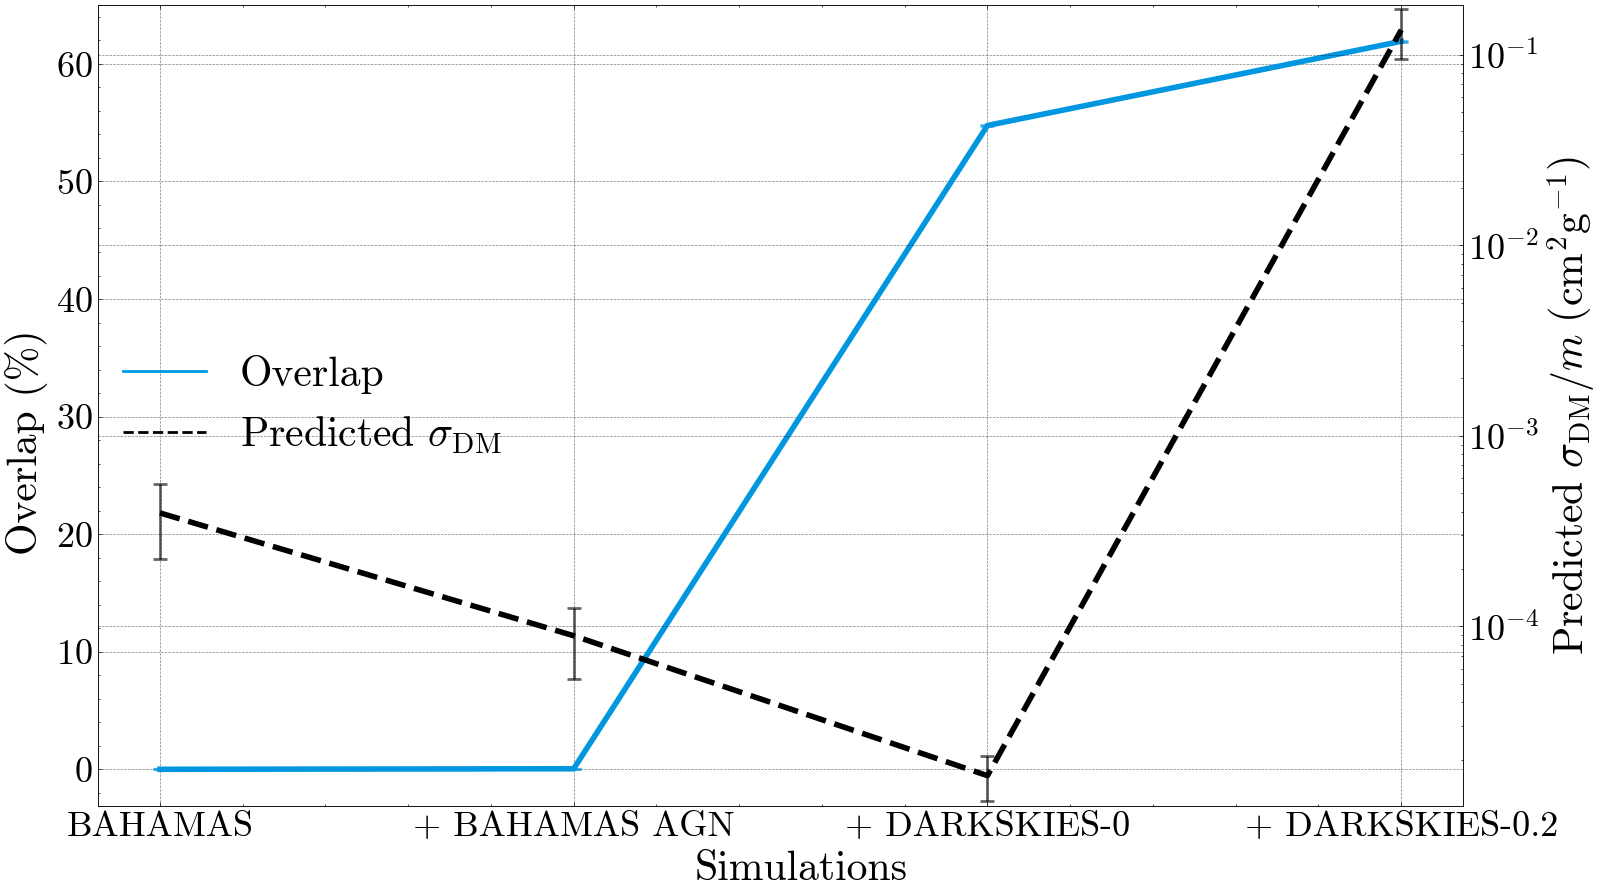

In [246]:
plot = plots.PlotPlots(
    ['BAHAMAS', '+ BAHAMAS AGN', '+ DARKSKIES-0', '   + DARKSKIES-0.2   '],
    # ['BAHAMAS', '+ BAHAMAS AGN', '+ FLAMINGO', '+ FLAMINGO AGN'],
    # [*y_data * 100, np.mean(confusion[0, 3:, ..., 0, 0], axis=-1), percentiles[0, 3:]][2:3],
    [*y_data[:, 0] * 100, np.mean(confusion[0, :, ..., 0, 0], axis=-1), percentiles[0, :]][2:3],
    x_label='Simulations',
    y_label='Overlap (%)',
    labels=['EMD', 'KS-Test', 'Overlap', 'Classification Accuracy', 'Percentile'][2:3],
    styles=['-'] * 4 + ['--'] * 1,
    # y_error=[*y_error, np.std(confusion[0, 3:, ..., 0, 0], ddof=1, axis=-1), None][2:3],
    y_error=[*y_data[:, 1], np.std(confusion[0, :, ..., 0, 0], ddof=1, axis=-1), None][2:3],
    colours=(bahamas_colours + bahamas_agn_colours)[2:3],
    line_width=4,
    axis=True,
    frameon=False,
    cols=1,
    major=30,
    minor=26,
    loc='center left',
)
plot.plot_twin_data(
    # quantiles[0, 0, 3:, 0],
    quantiles[0, 0, :, 4],
    y_label=r'Predicted $\sigma_{\rm DM}/m\ \left(\rm cm^2 g^{-1}\right)$',
    labels=[r'Predicted $\sigma_{\rm DM}$'],
    styles=['--'],
    log_y=True,
    colours=['k'],
    # y_error=np.array((quantiles[0, 0, 3:, 0] - quantiles[2, 0, 3:, 0], quantiles[3, 0, 3:, 0] - quantiles[0, 0, 3:, 0])),
    y_error=np.array((quantiles[0, 0, :, 4] - quantiles[2, 0, :, 4], quantiles[3, 0, :, 4] - quantiles[0, 0, :, 4])),
)
plot.set_axes_pad(pad=0.05)

In [ ]:
idx = slice(7, None)
# y_data = np.concat((np.min(emd_means[0, idx, 0], axis=-1), np.min(kstest_means[0, idx, 0], axis=-1), np.max(overlap_means[0, idx, 0], axis=-1)))
num = int(len(y_data) / 3)

plot = plots.PlotPlots(
    ['BAHAMAS', 'BAHAMAS AGN', 'BAHAMAS-DMO-0', 'BAHAMAS-DMO-1'],
    y_data,
    x_label='Simulations',
    y_label='Metric Score',
    labels=['EMD'] + ['KS-Stat'] + ['Overlap'],
    y_error=[
        emd_stes[0, idx, 0][np.arange(num), np.argmin(emd_means[0, idx, 0], axis=-1)],
        kstest_stes[0, idx, 0][np.arange(num), np.argmin(kstest_means[0, idx, 0], axis=-1)],
        overlap_stes[0, idx, 0][np.arange(num), np.argmax(overlap_means[0, idx, 0], axis=-1)],
    ],
    markers='',
)

In [15]:
labels

array(['FLAMINGO Low Test', 'FLAMINGO Low', 'FLAMINGO High', 'FLAMINGO',
       'BAHAMAS-0 Low', 'BAHAMAS-0 High', 'BAHAMAS-0', 'BAHAMAS-0.1',
       'BAHAMAS-0.3', 'BAHAMAS-1'], dtype='<U32')

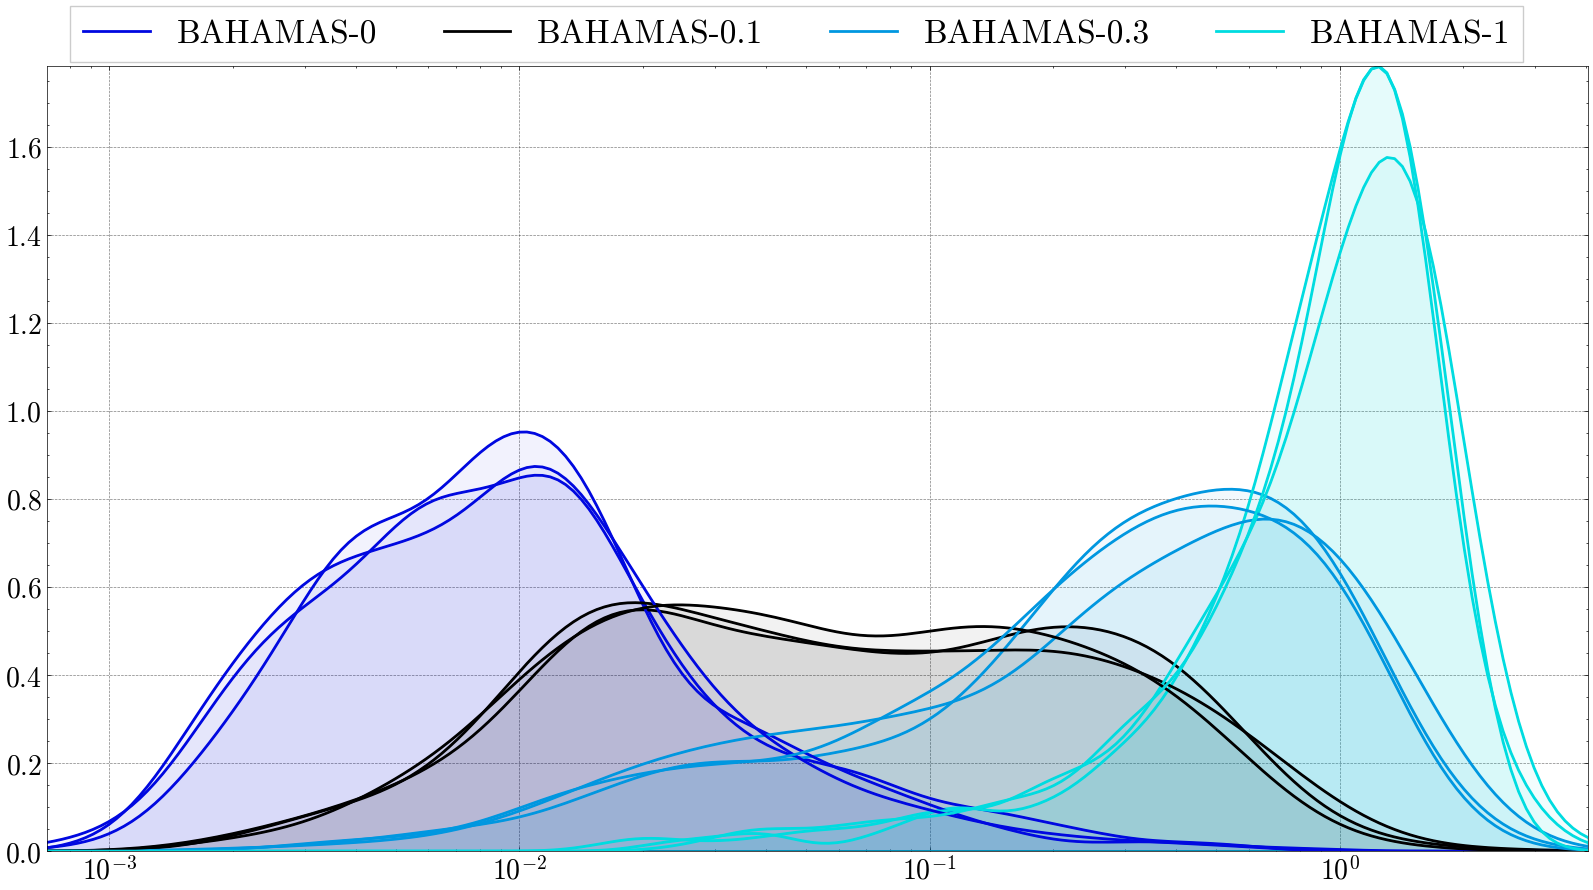

In [171]:
idx = (-1, 0)
sim_idx = slice(6, None)
# sim_idx = list(range(3, 6)) + list(range(7, distributions.shape[-1]))
# sim_idx = list(range(0, distributions.shape[-1]))
plot = plots.PlotDistribution(
    data['nets'][*idx, 0].transforms['targets'](distributions[*idx][:, sim_idx].reshape(-1), back=True),
    log=True,
    y_axes=True,
    density=True,
    # colours=np.tile(np.array(colours)[sim_idx], distributions.shape[-2]).tolist(),
    colours=np.tile(np.array(colours[:7] + ['k'] + colours[8:])[sim_idx], distributions.shape[-2]).tolist(),
    bins=200,
    labels=np.tile(np.array(labels)[sim_idx], distributions.shape[-2]).tolist(),
    alpha_2d=0.05,
)

In [174]:
for line, poly in zip(plot.plots[plot.axes][::2], plot.plots[plot.axes][1::2]):
    line.remove()
    poly.remove()
    plot.plots[plot.axes].remove(line)
    plot.plots[plot.axes].remove(poly)

    line.set_ydata(line.get_ydata() / np.sum(line.get_ydata()))
    verts = poly.get_paths()[0].vertices
    verts[:, 1] = verts[:, 1] / np.sum(verts[:, 1])
    poly.set_verts([verts])

    plot.axes.add_line(line)
    plot.axes.add_collection(poly)
    plot.plots[plot.axes].append(line)
    plot.plots[plot.axes].append(poly)

plot.set_axes_pad()

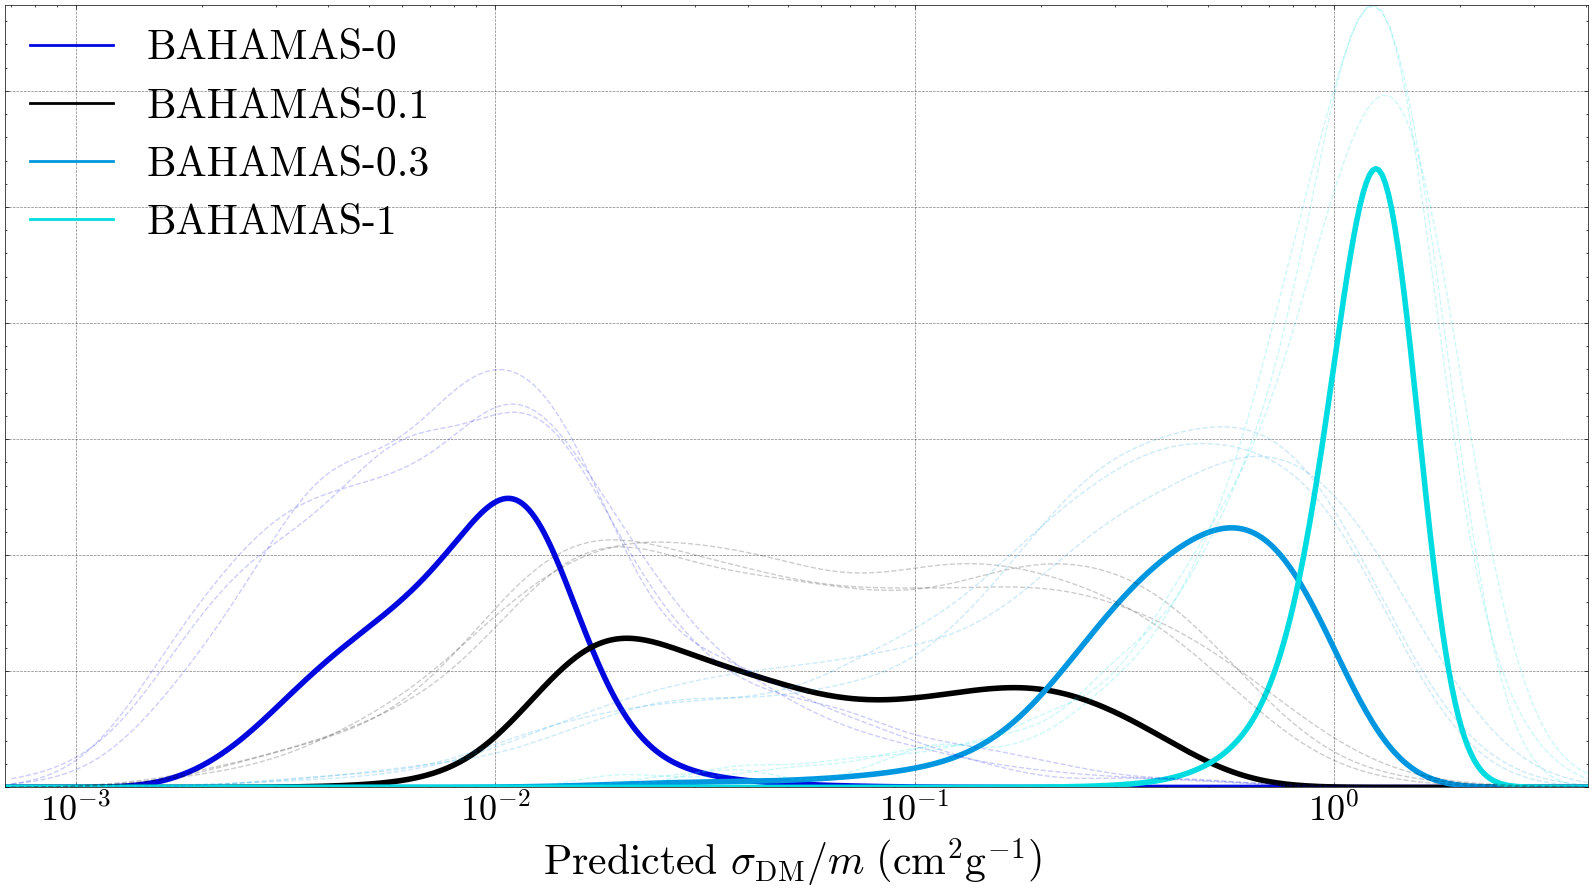

In [175]:
for line, poly in zip(plot.plots[plot.axes][::2], plot.plots[plot.axes][1::2]):
    plot2.plots[plot2.axes].append(plot2.axes.plot(*line.get_xydata().swapaxes(0, 1), color=line.get_color(), alpha=0.2, ls='--')[0])
    # plot2.plots[plot2.axes].append(poly)
    # plot2.axes.add_line(line)
    # plot2.axes.add_collection(poly)

plot2.set_axes_pad()
plot2.fig

(np.float64(5.1429482958389835e-06), np.float64(3.2755415119992506))

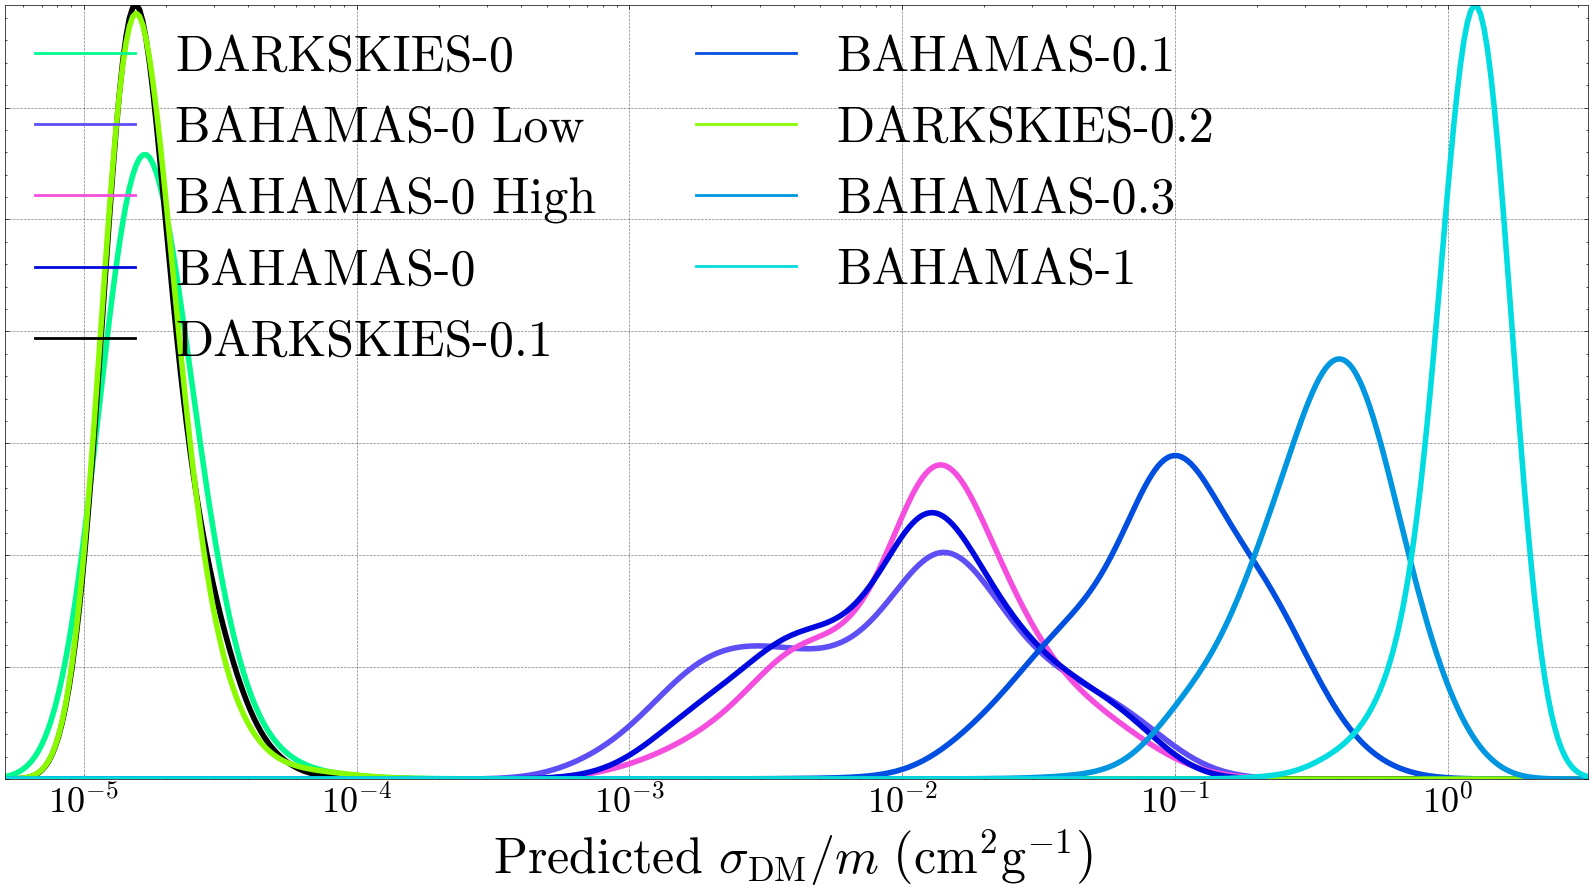

In [249]:
idx = (-1, 2)
# sim_idx = slice(6, None)
# sim_idx = [0, 3, 4, 5, 6, 7, 8]
# sim_idx = [3, 4, 5, 7, 8]
sim_idx = list(range(distributions.shape[-1]))
plot2 = plots.PlotPlots(
    grids[*idx],
    probs[*idx][sim_idx],
    log_x=True,
    x_label=r'Predicted $\sigma_{\rm DM}/m\ \left(\rm cm^2g^{-1}\right)$',
    # x_label=r'Self-Interaction Cross-Section',
    styles='-',
    labels=labels[sim_idx].tolist(),
    colours=np.array(colours)[sim_idx].tolist(),
    # colours=np.array(colours[:7] + ['k'] + colours[8:])[sim_idx].tolist(),
    axis=True,
    frameon=False,
    # loc=(0.15, 0.6),
    loc='upper left',
    cols=2,
    major=36,
    minor=26,
    line_width=4,
)
plot2.axes.tick_params(axis='y', labelleft=False)
plot2.axes.set_xlim(np.min(np.array(plot2._data)[(np.array(plot2._y_data) > 1e-4)]), np.max(np.array(plot2._data)[(np.array(plot2._y_data) > 1e-4)]))
# plot2.axes.set_xlim(np.min(np.repeat(grids[*idx][None], 5, axis=0)[(np.array(probs[*idx][[3, 4, 5, 7, 8]]) > 1e-4)]), np.max(np.repeat(grids[*idx][None], 5, axis=0)[(np.array(probs[*idx][[3, 4, 5, 7, 8]]) > 1e-4)]))

In [115]:
idx = -5
np.round(quantiles[0, *idxs, idx] - quantiles[2, *idxs, idx], 4), np.round(quantiles[3, *idxs, idx] - quantiles[0, *idxs, idx], 4)

(np.float64(0.0081), np.float64(0.0161))

In [66]:
idxs = (-1, -1)
pd.DataFrame(quantiles[:, *idxs].swapaxes(0, 1), index=labels, columns=[f'{quantile:.0%}' for quantile in quantile_values]).round(5)

,50%,5%,16%,84%,95%
FLAMINGO Low Test,0.01024,0.00434,0.00612,0.01341,0.01591
FLAMINGO Low,0.01157,0.00528,0.00782,0.01515,0.01844
FLAMINGO High,0.01157,0.00516,0.00763,0.01591,0.01936
FLAMINGO,0.01129,0.00491,0.00745,0.01553,0.01889
BAHAMAS-0 Low,0.00801,0.00301,0.00414,0.01408,0.02135
BAHAMAS-0 High,0.00999,0.00348,0.00516,0.01671,0.02598
BAHAMAS-0,0.00782,0.00324,0.00445,0.01408,0.02033
BAHAMAS-0.1,0.05976,0.01246,0.02033,0.15163,0.22998
BAHAMAS-0.3,0.31625,0.11581,0.18000,0.52904,0.74553
BAHAMAS-1,1.13074,0.56939,0.78297,1.55488,1.89159


In [16]:
idx = (-1, -3)
pd.DataFrame(quantiles[:, *idx].swapaxes(0, 1), index=labels, columns=[f'{quantile:.0%}' for quantile in quantile_values]).round(5)

,50%,5%,16%,84%,95%
FLAMINGO,0.00164,0.00072,0.00096,0.00320,0.00624
FLAMINGO High,0.00182,0.00080,0.00106,0.00364,0.00849
FLAMINGO Low,0.00137,0.00071,0.00089,0.00254,0.00624
BAHAMAS-0 High,0.00849,0.00192,0.00312,0.01880,0.04058
BAHAMAS-0 Low,0.00549,0.00145,0.00218,0.01382,0.02193
BAHAMAS-0,0.01347,0.00320,0.00640,0.02692,0.05244
BAHAMAS-0.1,0.17061,0.09705,0.12542,0.23812,0.28494
BAHAMAS-0.3,0.34983,0.22048,0.26384,0.46384,0.55504
BAHAMAS-1,1.00113,0.68144,0.79479,1.26103,1.43355


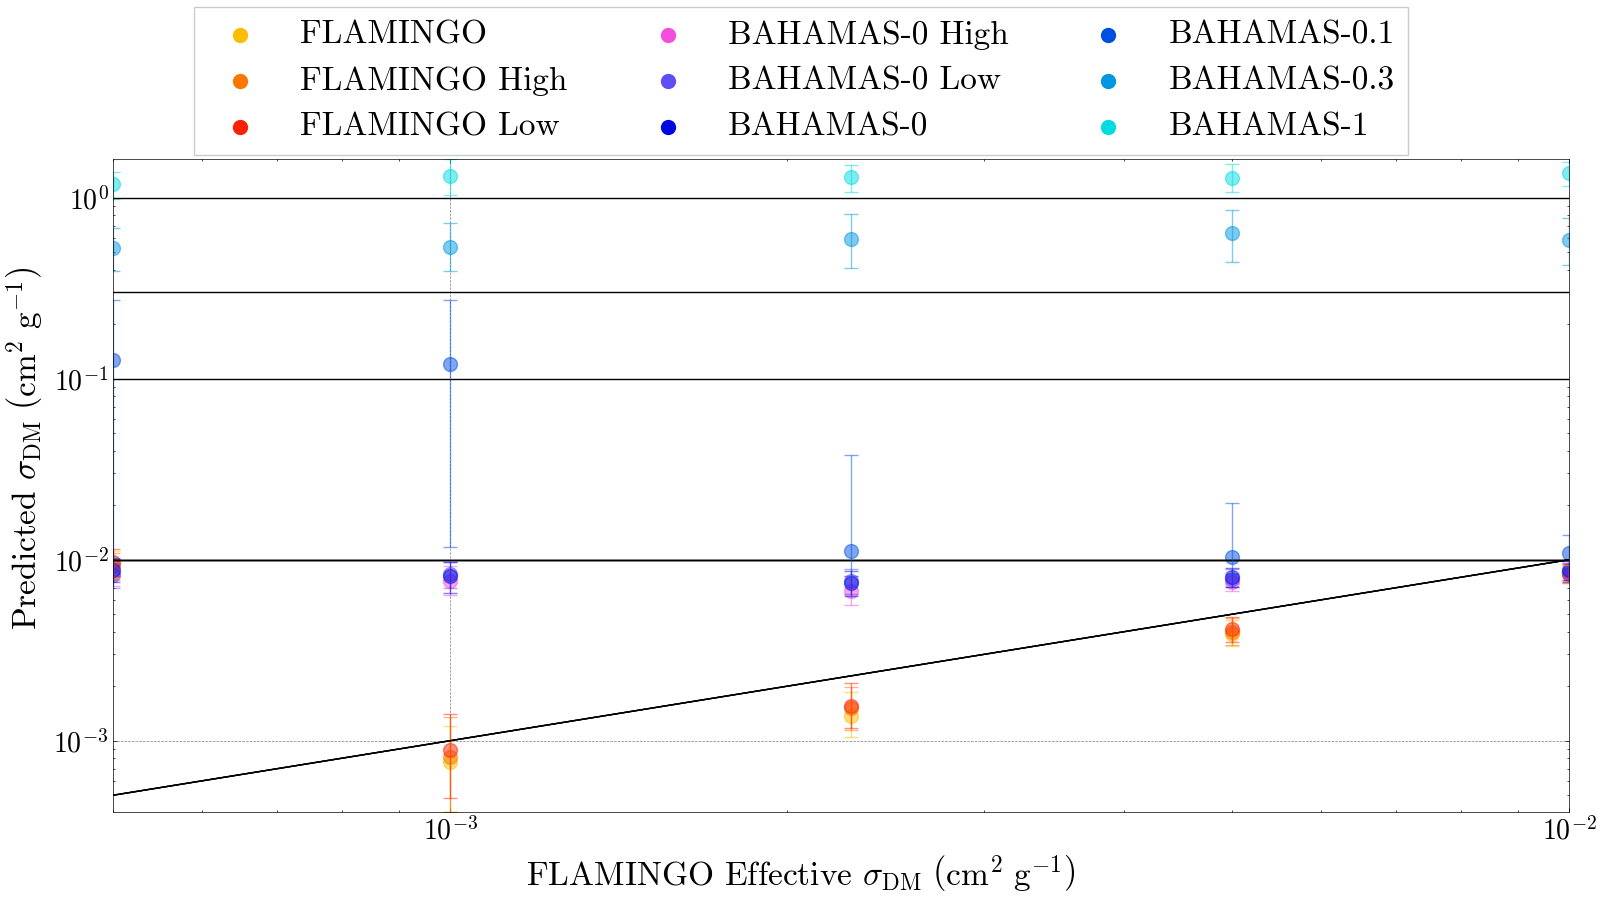

In [47]:
idx = (0, slice(3, 8))
x_data = np.array([5e-4, 1e-3, 2.28e-3, 5e-3, 1e-2])
targets = np.array(data['targets'][*idx, 0].tolist()).swapaxes(0, 1)
targets[:3] = np.ones_like(targets[:3]) * x_data

plot = plots.PlotComparison(
    x_data,
    quantiles[0, *idx].swapaxes(0, 1),
    log_x=True,
    log_y=True,
    x_label=r'FLAMINGO Effective $\sigma_{\rm DM}\ \left(\rm cm^2\ g^{-1}\right)$',
    y_label=r'Predicted $\sigma_{\rm DM}\ \left(\rm cm^2\ g^{-1}\right)$',
    labels=labels.tolist(),
    target=targets,
    y_error=np.transpose(np.abs(quantiles[[2, 3], *idx] - quantiles[0, *idx]), [2, 0, 1]),
    alpha_marker=0.5,
    markers='o',
    colours=colours,
    fig_size=(16,9),
)

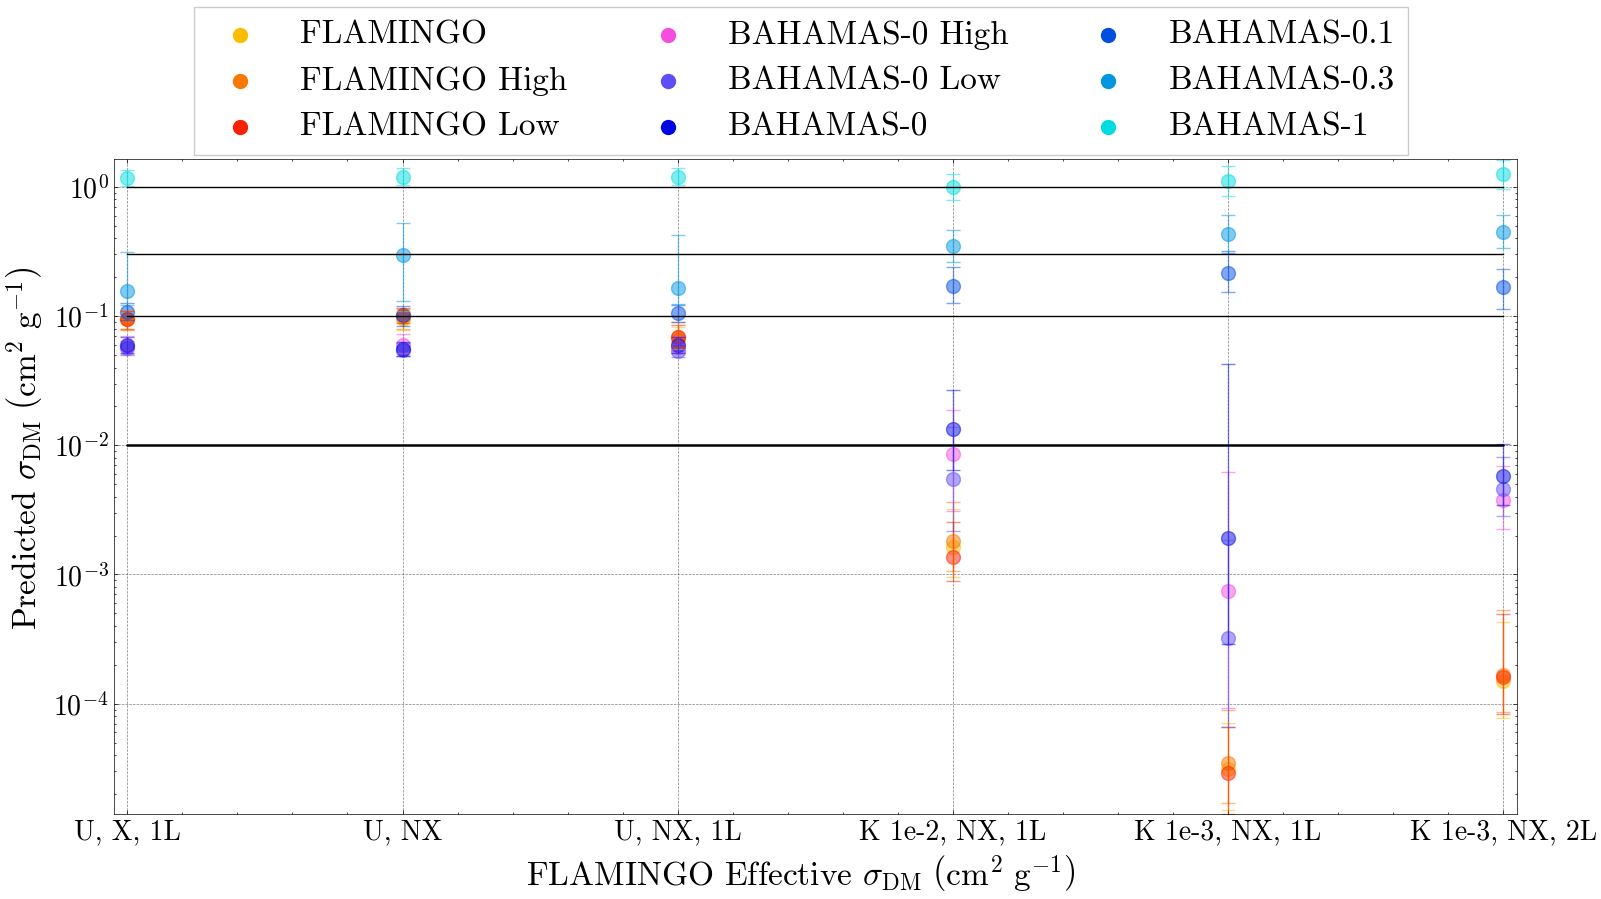

In [48]:
idxs = [0, 1, 2, -3, -2, -1]
x_data = np.array([
    'U, X, 1L', 'U, NX', 'U, NX, 1L', 'K 1e-2, NX, 1L', 'K 1e-3, NX, 1L', 'K 1e-3, NX, 2L',])

plot = plots.PlotComparison(
    x_data,
    quantiles[0, 0, idxs].swapaxes(0, 1),
    log_y=True,
    x_label=r'FLAMINGO Effective $\sigma_{\rm DM}\ \left(\rm cm^2\ g^{-1}\right)$',
    y_label=r'Predicted $\sigma_{\rm DM}\ \left(\rm cm^2\ g^{-1}\right)$',
    labels=labels.tolist(),
    target=[*[np.ones(len(x_data)) * 1e-2] * 6, np.ones(len(x_data)) * 0.1, np.ones(len(x_data)) * 0.3, np.ones(len(x_data))],
    y_error=np.transpose(np.abs(quantiles[[2, 3], 0][:, idxs] - quantiles[0, 0, idxs]), [2, 0, 1]),
    alpha_marker=0.5,
    markers='o',
    colours=colours,
    fig_size=(16,9),
)
plot.set_axes_pad(pad=0.01)

In [ ]:
idx = (slice(None), -1)
x_data = np.array([5e-4, 1e-3, 2.28e-3, 5e-3, 1e-2])

plot = plots.PlotComparison(
    # np.array(['SIDM Only', 'Linear', 'X-Ray', 'CDM Unknown', 'CDM Known', 'AGN Known', 'X-Ray']),
    x_data,
    quantiles[0, *idx].swapaxes(0, 1),
    log_x=True,
    log_y=True,
    # error_region=True,
    x_label=r'FLAMINGO Effective $\sigma_{\rm DM}\ \left(\rm cm^2\ g^{-1}\right)$',
    y_label=r'Predicted $\sigma_{\rm DM}\ \left(\rm cm^2\ g^{-1}\right)$',
    labels=labels.tolist(),
    target=np.array(data['targets'][:, -1, 0].tolist()).swapaxes(0, 1)[1:],
    y_error=np.transpose(np.abs(quantiles[[2, 3], *idx] - quantiles[0, *idx]), [2, 0, 1]),
    # y_error=np.transpose(np.abs(quantiles[[2, 3], *idx]), [2, 0, 1]),
    alpha_marker=0.5,
    markers='o',
    colours=colours,
)

In [ ]:
idx = (slice(None), -1)
for colour, pred, uncertainty in zip(colours, quantiles[0, *idx].swapaxes(0, 1), np.transpose(np.abs(quantiles[[2, 3], *idx] - quantiles[0, *idx]), [2, 0, 1])):
    plot.plot_errors(
        colour,
        [1.5e-2],
        pred,
        plot.axes,
        marker='v',
        y_error=uncertainty,
    )
plot.set_axes_pad(pad=0.05)
plot.fig

In [45]:
quantiles = np.empty((len(quantile_values), *distributions.shape))

for i, percentile in enumerate(quantile_values):
    for shape in np.ndindex(distributions.shape):
        quantiles[i, *shape] = np.quantile(data['nets'][idx, 0].transforms['targets'](distributions[*shape], back=True), percentile)

In [47]:
quantiles = np.empty((len(quantile_values), *distributions[:, 0].shape))

for i, percentile in enumerate(quantile_values):
    for j, k in np.ndindex(quantiles.shape[1:]):
        quantiles[i, j, k] = np.quantile(data['nets'][j, 0].transforms['targets'](np.concat(distributions[j, :, k]), back=True), percentile)

In [ ]:
quantiles[:, -1, -1]
pd.DataFrame(quantiles[:, idx].swapaxes(0, 1), index=labels, columns=[f'{quantile:.0%}' for quantile in quantile_values]).round(3)

In [46]:
np.mean(quantiles, axis=2)[:, -1, -1]

array([1.03375434, 0.0979512 , 0.25168536, 2.29365348, 3.54753702])

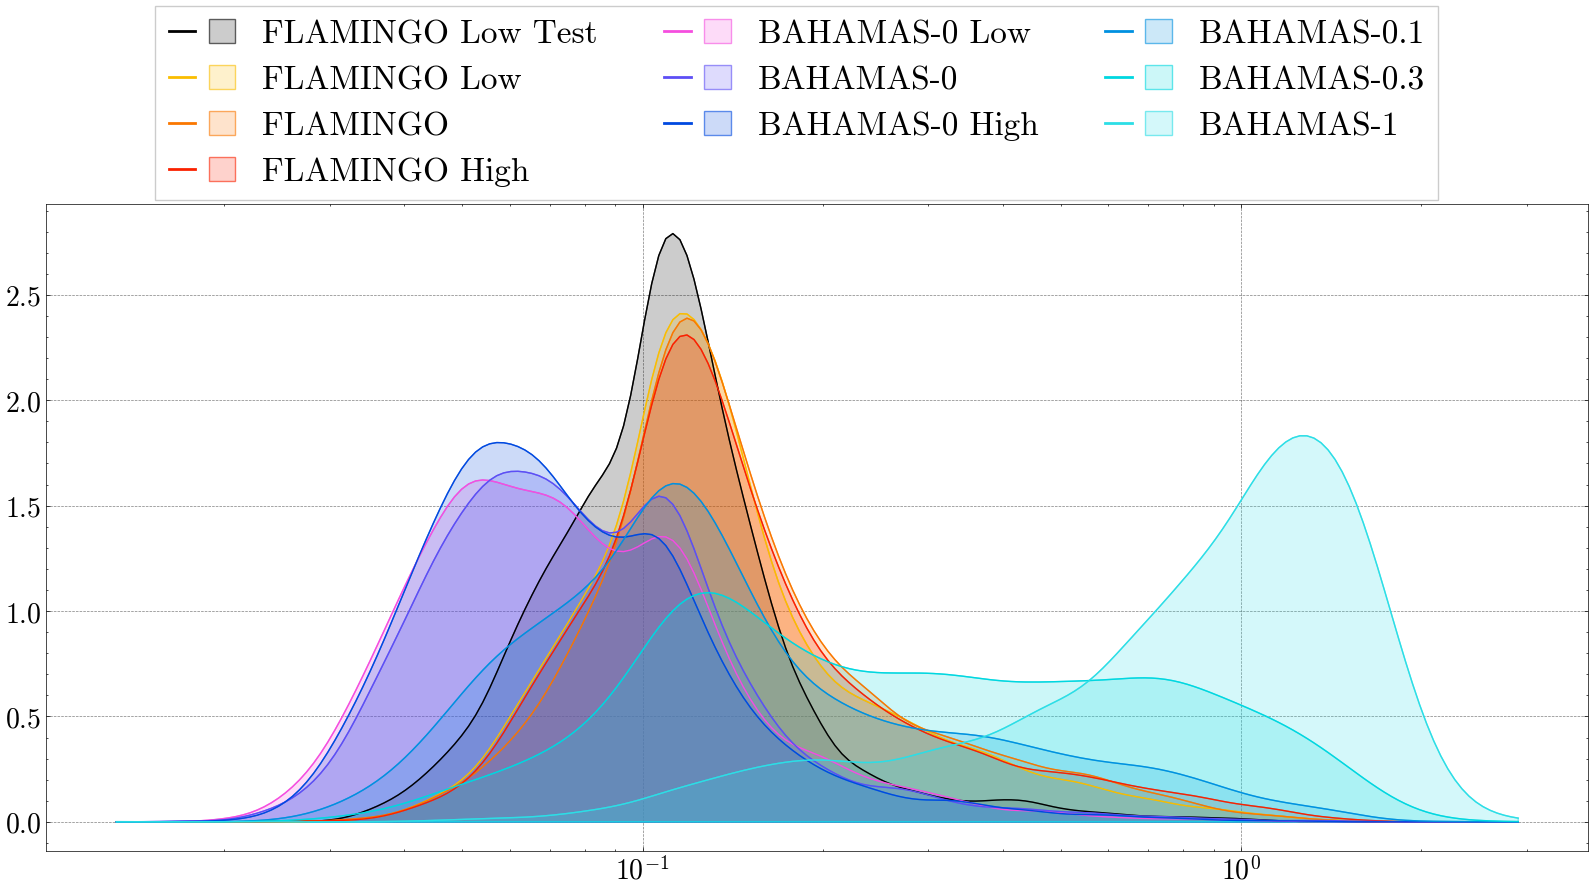

In [103]:
idx = -1
plot = plots.PlotDistribution(
    # [distributions[0, 0, 0]],
    [data['nets'][idx, 0].transforms['targets'](np.concat(distribution), back=True) for distribution in distributions[idx].swapaxes(0, 1)],
    # [data['nets'][idx, 0].transforms['targets'](distribution, back=True) for distribution in distributions[idx, 0]],
    log=True,
    density=True,
    colours=colours,
    # colours=colours,
    bins=200,
    labels=labels,
    alpha_2d=0.2,
)